# Isopycnal slopes

Computes and plots the mean depth-averaged isopycnal slopes for a set of four CESM2-MOM6 simulations.

In [1]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']
c= ['xkcd:black','xkcd:grey','xkcd:dark red','xkcd:dark orange'] 


loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])

alpha_res = 2.
p_res = 50
def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 12

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='01:00:00')
    cluster.scale(nw)
    client = Client(cluster)

client

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/34747/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/34747/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.177:39321,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/34747/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Compute isopycnal slopes

In [4]:
def dens_wright_eos(T, S, z):
    """
    Equation of state for sea water given by Wright, 1997, J. Atmos. Ocean. Tech., 14, 735-740.
    Units: T[degC],S[PSU],z[m]   (was p[Pa])
    Returns density [kg m-3]
    """

    p = 9.8 * 1020.41 * z  # AJA was using 1025.0 not 1020.41, and z=2000.

    a0 = 7.057924e-4; a1 = 3.480336e-7; a2 = -1.112733e-7
    b0 = 5.790749e8;  b1 = 3.516535e6;  b2 = -4.002714e4; b3 = 2.084372e2;  b4 = 5.944068e5;  b5 = -9.643486e3
    c0 = 1.704853e5;  c1 = 7.904722e2;  c2 = -7.984422;   c3 = 5.140652e-2; c4 = -2.302158e2; c5 = -3.079464

    al0 = a0 + a1 * T + a2 * S
    p0 = b0 + b4 * S + T * (b1 + T * (b2 + b3 * T) + b5 * S)
    l = c0 + c4 * S + T * (c1 + T * (c2 + c3 * T) + c5 * S)

    dens = (p + p0) / (l + al0*(p+p0))
    if isinstance(T, xr.DataArray):
        return dens.assign_attrs(units=r"kg m$^{-3}$", standard_name="Density-like")
    return dens


Re = 6370e3      #   [m]
deg2rad = np.pi / 180

In [5]:
%%time

res_funcs = []

for sim in tqdm(sims):
    sim.open_files_by_year(sim.ocn_data_path, 
                           sim.native_end,
                           start_year, 
                           end_year,
                           preprocess=lambda ds: ds[["thetao", "so", "depth_ocean","Rd_dx",'area_t','wet']],
                           chunks = {"yh":150, "xh":576})
    sim.open_grid()


    Rd_dx = sim.ds.Rd_dx.mean('time').compute()    
    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)


  0%|          | 0/4 [00:00<?, ?it/s]

Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.


 25%|██▌       | 1/4 [00:26<01:19, 26.54s/it]

Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.


 50%|█████     | 2/4 [00:44<00:42, 21.27s/it]

Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.


 75%|███████▌  | 3/4 [01:00<00:19, 19.22s/it]

Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.


100%|██████████| 4/4 [01:18<00:00, 19.55s/it]

CPU times: user 43.6 s, sys: 1.6 s, total: 45.2 s
Wall time: 1min 18s


In [9]:
def d_of_targ_raw(sigma3d, depths1d, topo2d, targ2d, zmin):
    # Assumes lateral dimensions of arguments all match each other
    nj, ni = targ2d.shape
    z = np.nan * np.zeros((nj, ni))
    zz = depths1d[::-1] # Note reversal of k
    for j in range(nj):
        for i in range(ni):
            t = targ2d[j, i]
            if topo2d[j, i] > 0:
                z[j, i] = np.maximum(np.interp(-t, -sigma3d[:, j, i][::-1], zz), zmin)
                z[j, i] = np.minimum(z[j, i], topo2d[j, i])
    return z


def d_of_targ(sigma, depths, topo, targ, zmin):
    # Unpack xarray to numpy arrays
    sigma3d = sigma.sel(targ.coords).ffill(dim='zl').values
    depths1d = depths.values
    topo2d = topo.sel(targ.coords).values
    targ2d = targ.values

    new_depths = np.nan * targ
    new_depths.loc[:, :] = d_of_targ_raw(sigma3d, depths1d, topo2d, targ2d, zmin)
    new_depths = new_depths.where(topo > 0)
    return new_depths

In [66]:
Z_REF = 2000.0            # metres   
for sim in sims:
    ds = sim.ds
    
    sigma2 = dens_wright_eos(ds.thetao, ds.so, Z_REF)
    
    ds['sigma2'] = sigma2
    ds['sigma2'].attrs.update(
        long_name = fr'potential density σ₂ (referenced to {Z_REF:.0f} m)',
        units     = 'kg m-3'
    )

print("✓  σ₂ added to:", [sim.short_name for sim in sims])

✓  σ₂ added to: ['REF', 'GM', 'GM+MBK', 'GM+LBK']


In [67]:
deg2rad = np.pi / 180.0
Re      = 6_370_000.0     # Earth’s radius [m]

coslat = np.cos(deg2rad * ds['yh'])   # (yh)
dx_fac = deg2rad * Re * coslat        # metres per degree lon at each latitude
dy_fac = deg2rad * Re                 # metres per degree lat (constant)

ψ_hi, ψ_lo = 0.8, 0.2     # thresholds for “on / mid / off”

In [9]:
%%time

deg2rad, Re = np.pi/180.0, 6_370_000.0

maps = {}

for sim in tqdm(sims, desc="simulations"):
    ds = sim.ds

    # 1) mask and time-mean the density field
    wet3d  = ds['wet'] == 1
    topo3d = xr.broadcast(ds['zl'], ds['depth_ocean'])[1]
    sigma2 = (
        ds['sigma2']
          .where(wet3d)
          .where(ds['zl'] < topo3d)
          .mean(dim='time')              # <— collapse time first
    )

    # 2) compute gradients of the mean field
    coslat = np.cos(deg2rad * ds['yh'])
    dx_fac = deg2rad * Re * coslat
    dy_fac = deg2rad * Re

    drdx = xr.apply_ufunc(
        np.gradient, sigma2,
        kwargs={'axis': -1, 'edge_order': 2},
        input_core_dims=[['xh']], output_core_dims=[['xh']],
        dask='parallelized', output_dtypes=[sigma2.dtype],
        dask_gufunc_kwargs={'allow_rechunk': True}
    ) / dx_fac

    drdy = xr.apply_ufunc(
        np.gradient, sigma2,
        kwargs={'axis': -2, 'edge_order': 2},
        input_core_dims=[['yh']], output_core_dims=[['yh']],
        dask='parallelized', output_dtypes=[sigma2.dtype],
        dask_gufunc_kwargs={'allow_rechunk': True}
    ) / dy_fac

    drdz = sigma2.differentiate('zl')

    # 3) slope magnitude of the time-mean field
    Smean = xr.where(
        np.abs(drdz) > 1e-8,
        np.sqrt(drdx**2 + drdy**2) / np.abs(drdz),
        np.nan
    )

    # 4) build vertical thickness array dz(zl)
    dz_iface = ds['zl'].diff('zl')
    dz = dz_iface.pad(zl=(0, 1), constant_values=dz_iface.isel(zl=-1))
    dz = dz.assign_coords(zl=ds['zl'])
    water_mask = wet3d[0] & (ds['zl'] < topo3d[:,0,:,:])
    dz_wat = dz.where(water_mask)

    # 5) full-column thickness-weighted mean slope of the mean field
    H_full    = dz_wat.sum(dim='zl')
    S_w_full  = (Smean * dz_wat).sum(dim='zl') / H_full
    Sbar_full = S_w_full.compute()

    # 6) top 1 km thickness-weighted mean slope of the mean field
    top_mask     = water_mask & (ds['zl'] <= 1000)
    dz_top        = dz.where(top_mask)
    H_top         = dz_top.sum(dim='zl')
    S_top         = Smean.where(top_mask)
    S_w_top       = (S_top * dz_top).sum(dim='zl') / H_top
    Sbar_top1km   = S_w_top.compute()

    maps[sim.short_name] = {
        'full-depth': Sbar_full,
        '0-1000m':    Sbar_top1km
    }

simulations:   0%|          | 0/4 [00:00<?, ?it/s]/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 9.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 9.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
simulations:  25%|██▌       | 1/4 [11:39<34:58, 699.54s/it]/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 9.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning

CPU times: user 15min 13s, sys: 58.3 s, total: 16min 12s
Wall time: 52min 20s


### Plot 

In [10]:
ds = xr.open_dataset("mean_slope_maps_full_and_0-1000m.nc")

maps = {}
for varname in ds.data_vars:
    sim_name, variant_token = varname.split("_", 1)
    variant = variant_token.replace("_", "-")
    maps.setdefault(sim_name, {})[variant] = ds[varname]

# Verify:
print("Nested maps keys:", maps.keys())
print("Variants for GM:", maps["GM"].keys())

Nested maps keys: dict_keys(['REF', 'GM', 'GM+MBK', 'GM+LBK'])
Variants for GM: dict_keys(['full-depth', '0-1000m'])


  0%|          | 0/5 [00:00<?, ?it/s]

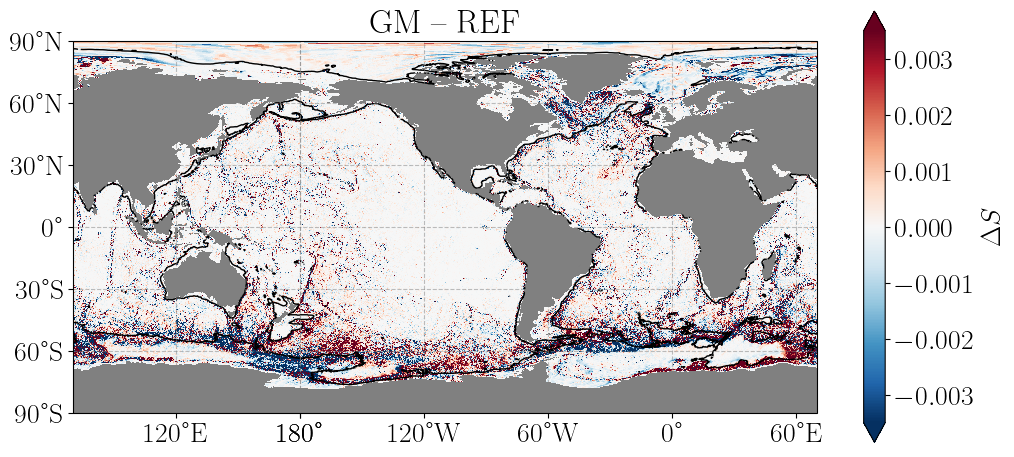

 20%|██        | 1/5 [00:06<00:26,  6.62s/it]

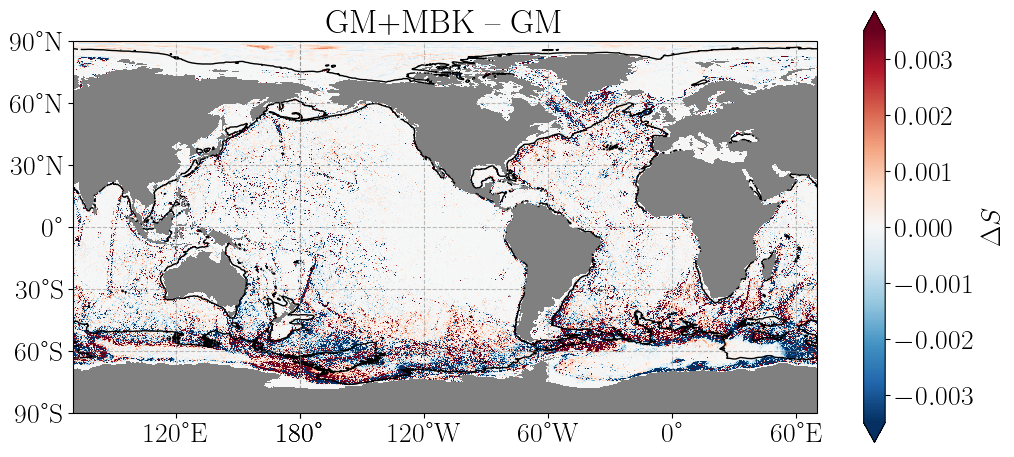

 40%|████      | 2/5 [00:11<00:16,  5.44s/it]

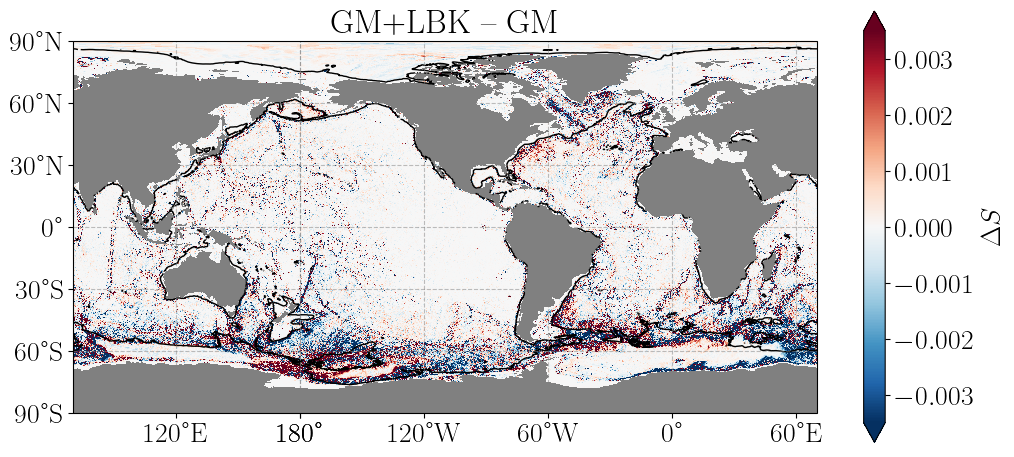

 60%|██████    | 3/5 [00:16<00:10,  5.22s/it]

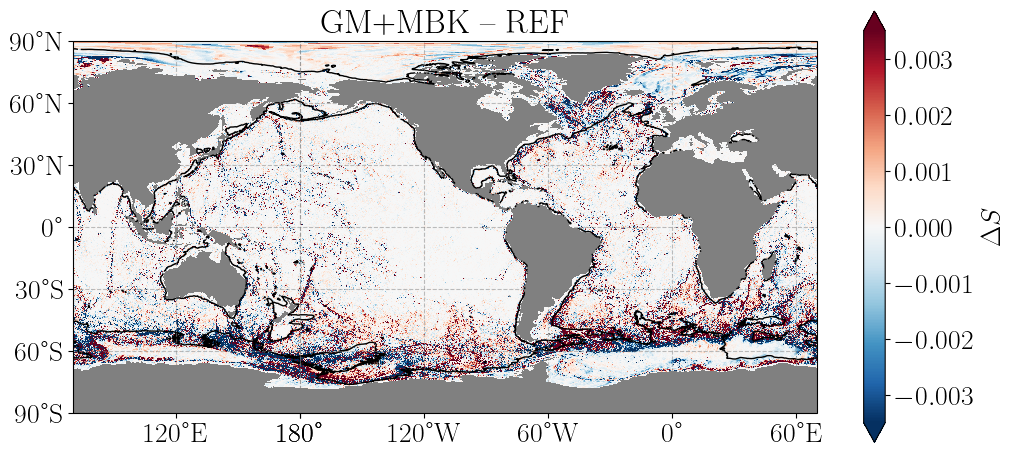

 80%|████████  | 4/5 [00:20<00:04,  4.95s/it]

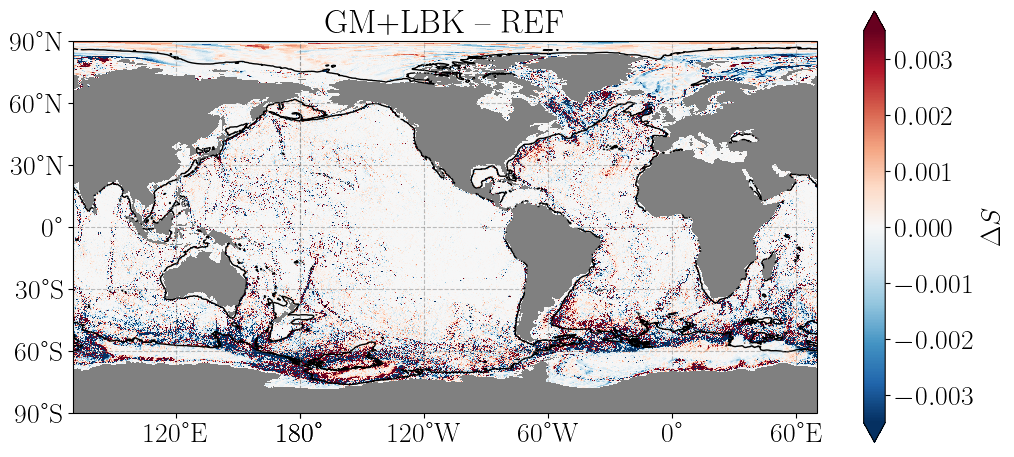

100%|██████████| 5/5 [00:25<00:00,  5.07s/it]

CPU times: user 21.9 s, sys: 684 ms, total: 22.6 s
Wall time: 25.6 s


In [7]:
%%time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

first_key = next(iter(maps))
nested = isinstance(maps[first_key], dict)
def get_map(exp, variant):
    return maps[exp][variant] if nested else maps[(exp, variant)]

comparisons = [
    ('GM',     'REF',    'GM – REF', 1),
    ('GM+MBK','GM',     'GM+MBK – GM', 2),
    ('GM+LBK','GM',     'GM+LBK – GM', 3),
    ('GM+MBK','REF',    'GM+MBK – REF', 2),
    ('GM+LBK','REF',    'GM+LBK – REF', 3),
]

variants = ['full-depth']
variant_labels = {'full-depth': '', '0-1000m': ''}

vmax = 0.35e-2
for variant in variants:
    # compute symmetric discrete levels
    dS_list = [get_map(e1, variant) - get_map(e0, variant)
               for e1, e0, _, _ in comparisons]
    levels = np.linspace(-vmax, vmax, 9)  # 8 bands
    for exp1, exp0, title, i in tqdm(comparisons):
        dS  = get_map(exp1, variant) - get_map(exp0, variant)
        sim = next(s for s in sims if s.short_name == exp1)

        mappable = sim.plot_global(
            field             = dS,
            vmin = -vmax,
            vmax =  vmax,
            R                 = res_funcs[i],
            R_threshold       = 0.8,
            contour_color     = 'xkcd:black',
            contour_linewidth = 1.,
            contour_linestyle = '-',
            cmap              = plt.cm.RdBu_r,
            cbar_label        = r'$\Delta S$',
            title             = f"{title}",
            figsize           =(12,8)
        )

        cbar = mappable.colorbar
        cbar.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1e'))

        ax = plt.gca()
    
        # set up graticules
        lon_ticks = np.arange(-180, 181, 60)
        lat_ticks = np.arange(-90, 91, 30)
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
        plt.savefig(save_path+'Slope_map_'+title+'_full_depth.png',dpi=300)
        plt.show()

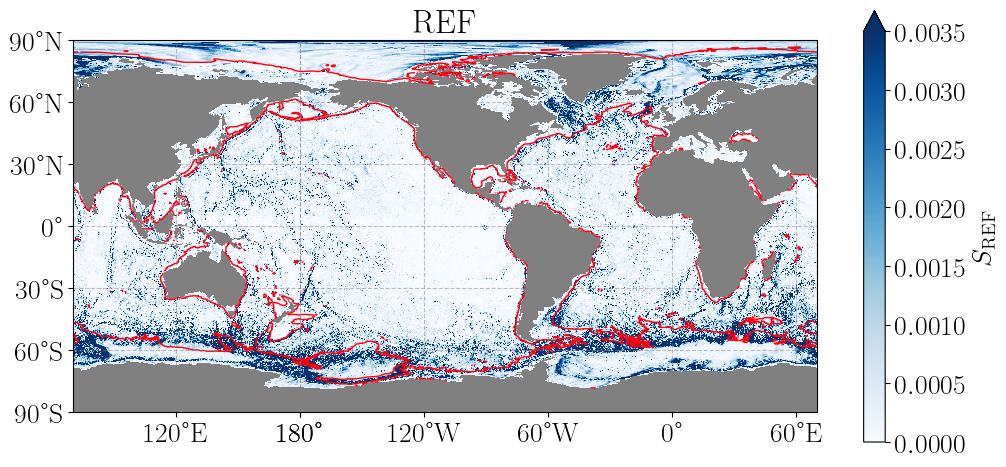

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# helper to grab the right map variant
first_key = next(iter(maps))
nested = isinstance(maps[first_key], dict)
def get_map(exp, variant):
    return maps[exp][variant] if nested else maps[(exp, variant)]

# parameters
variant  = 'full-depth'
exp      = 'REF'
vmax     = 0.35e-2
res_func = res_funcs[0]  

# grab the REF field
S_ref = get_map(exp, variant)

# find the simulation object
sim_ref = next(s for s in sims if s.short_name == exp)

# plot it
mappable = sim_ref.plot_global(
    field             = S_ref,
    vmin              =   0,
    vmax              = vmax,
    R                 = res_func,
    R_threshold       = 0.8,
    contour_color     = 'xkcd:bright red',
    contour_linewidth = 1.,
    contour_linestyle = '-',
    cmap              = cm.Blues,      # switch to a single‐colormap
    cbar_label        = r'$S_{\rm REF}$',
    title             = f"REF",
    figsize           = (12, 8)
)

# format the colorbar
cbar = mappable.colorbar
cbar.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1e'))

# add graticules
ax = plt.gca()
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)

# save and show
plt.savefig(save_path + 'REF_full_depth.png', dpi=300)
plt.show()

### Create a table of mean isopycnal slopes

In [69]:
%%time
area2d = sims[0].ds.area_t[0]
mean_map = {}
for sname in snames:
    Sbar = maps[sname]['full-depth']
    num_full = (Sbar * area2d).sum(dim=('yh','xh'))
    den_full = area2d.sum(dim=('yh','xh'))
    global_mean_full = (num_full / den_full).compute()

    Sbar = maps[sname]['0-1000m']
    num_0_1km = (Sbar * area2d).sum(dim=('yh','xh'))
    den_0_1km = area2d.sum(dim=('yh','xh'))
    global_mean_0_1km = (num_0_1km / den_0_1km).compute()
    
    mean_map[sname] = {
        'global_full-depth':  global_mean_full,
        'global_0-1000m':     global_mean_0_1km
    }

CPU times: user 1.06 s, sys: 126 ms, total: 1.19 s
Wall time: 2.51 s


In [70]:
for sname in mean_map.keys():
    print(mean_map[sname]['global_full-depth'].values)

0.0011806752363862267
0.0011842266213007466
0.0011434629918052703
0.0011004737328361963


In [71]:
for sname in mean_map.keys():
    print(mean_map[sname]['global_0-1000m'].values)

0.0013121678446902315
0.0013309943359232142
0.0012357734132512138
0.0013606336102694818


In [72]:
names_nonref = ['GM','GM+MBK','GM+LBK']
psi_nonref = {}
for name in names_nonref:
    sim = next(s for s in sims if s.short_name == name)
    Rd_dx = sim.ds['Rd_dx'].mean(dim='time')
    psi_nonref[name] = resolution(Rd_dx, alpha_res, p_res).fillna(0.)

ψ_hi, ψ_lo = 0.8, 0.2
on2d  = (psi_nonref['GM']     >= ψ_hi) & (psi_nonref['GM+MBK'] >= ψ_hi) & (psi_nonref['GM+LBK'] >= ψ_hi)
off2d = (psi_nonref['GM']     <= ψ_lo) & (psi_nonref['GM+MBK'] <= ψ_lo) & (psi_nonref['GM+LBK'] <= ψ_lo)
mid2d = (~on2d) & (~off2d)
mask2d = {
    'global': xr.ones_like(on2d, dtype=bool),
    'on':     on2d,
    'mid':    mid2d,
    'off':    off2d,
}

In [73]:
%%time
mean_map = {}
for sname, variants in maps.items():
    mean_map[sname] = {}
    for varname, Sbar in variants.items():  # varname is 'full-depth' or '0-1000m'
        for region, m2d in mask2d.items():
            # mask slope and area
            S_reg = Sbar.where(m2d)
            A_reg = area2d.where(m2d)

            num = (S_reg * A_reg).sum(dim=('yh','xh'))
            den = A_reg.sum(dim=('yh','xh'))
            mean_map[sname][f"{region}_{varname}"] = (num/den).compute()

rows = []
for sim, regs in mean_map.items():
    for key, val in regs.items():
        region, variant = key.split('_',1)
        rows.append({
            'simulation': sim,
            'region':     region,
            'variant':    variant,
            'mean_slope': float(val)
        })
df_means = pd.DataFrame(rows)
display(df_means)

,simulation,region,variant,mean_slope
0,REF,global,full-depth,0.001181
1,REF,on,full-depth,0.003944
2,REF,mid,full-depth,0.006548
3,REF,off,full-depth,0.000643
4,REF,global,0-1000m,0.001312
5,REF,on,0-1000m,0.002380
6,REF,mid,0-1000m,0.002051
7,REF,off,0-1000m,0.001145
8,GM,global,full-depth,0.001184
9,GM,on,full-depth,0.003192


In [74]:
pivot = df_means.pivot(
    index=['region','variant'],
    columns='simulation',
    values='mean_slope'
)

for sim in ['GM','GM+MBK','GM+LBK']:
    pivot[f'{sim}_vs_REF'] = pivot[sim] - pivot['REF']

pivot['GM+MBK_vs_GM'] = pivot['GM+MBK'] - pivot['GM']
pivot['GM+LBK_vs_GM'] = pivot['GM+LBK'] - pivot['GM']

diff_df = pivot[
    ['GM_vs_REF', 'GM+MBK_vs_REF', 'GM+LBK_vs_REF',
     'GM+MBK_vs_GM', 'GM+LBK_vs_GM']
].reset_index()

diff_df

simulation,region,variant,GM_vs_REF,GM+MBK_vs_REF,GM+LBK_vs_REF,GM+MBK_vs_GM,GM+LBK_vs_GM
0,global,0-1000m,0.000019,-0.000076,0.000048,-0.000095,0.000030
1,global,full-depth,0.000004,-0.000037,-0.000080,-0.000041,-0.000084
2,mid,0-1000m,-0.000151,-0.000237,0.000081,-0.000086,0.000232
3,mid,full-depth,-0.000705,-0.001096,-0.001321,-0.000390,-0.000615
4,off,0-1000m,0.000060,-0.000050,0.000084,-0.000110,0.000024
5,off,full-depth,0.000127,0.000073,0.000076,-0.000054,-0.000052
6,on,0-1000m,-0.000249,-0.000235,-0.000225,0.000014,0.000024
7,on,full-depth,-0.000752,-0.000611,-0.000953,0.000141,-0.000201


In [76]:
pivot = df_means.pivot(
    index=['region','variant'],
    columns='simulation',
    values='mean_slope'
)

for sim in ['GM','GM+MBK','GM+LBK']:
    pivot[f'{sim}_vs_REF'] = pivot[sim] - pivot['REF']

pivot['GM+MBK_vs_GM'] = pivot['GM+MBK'] - pivot['GM']
pivot['GM+LBK_vs_GM'] = pivot['GM+LBK'] - pivot['GM']

diff_df = pivot[
    ['GM_vs_REF', 'GM+MBK_vs_REF', 'GM+LBK_vs_REF',
     'GM+MBK_vs_GM', 'GM+LBK_vs_GM']
].reset_index()

to_scale = ['GM_vs_REF',
            'GM+MBK_vs_REF',
            'GM+LBK_vs_REF',
            'GM+MBK_vs_GM',
            'GM+LBK_vs_GM']

diff_df[to_scale] = diff_df[to_scale] * 1e4

diff_df

simulation,region,variant,GM_vs_REF,GM+MBK_vs_REF,GM+LBK_vs_REF,GM+MBK_vs_GM,GM+LBK_vs_GM
0,global,0-1000m,0.188265,-0.763944,0.484658,-0.952209,0.296393
1,global,full-depth,0.035514,-0.372122,-0.802015,-0.407636,-0.837529
2,mid,0-1000m,-1.510322,-2.370781,0.813026,-0.860459,2.323347
3,mid,full-depth,-7.054912,-10.957399,-13.208256,-3.902486,-6.153343
4,off,0-1000m,0.601763,-0.500827,0.843184,-1.102590,0.241420
5,off,full-depth,1.273057,0.728442,0.757021,-0.544616,-0.516036
6,on,0-1000m,-2.489737,-2.347753,-2.249115,0.141983,0.240622
7,on,full-depth,-7.520560,-6.113371,-9.526796,1.407189,-2.006235
